In [80]:
import time
from scipy.stats import median_absolute_deviation
import scipy.stats
import numpy as np
import pandas as pd
import sqlite3
from tqdm import tqdm
import glob
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from functools import partial, reduce
import plotnine as gg


In [110]:
top_dir = '/Users/habbasi/Desktop/'
proj_dir = 'TA'
batch= 'SIGMA2_Pilot_2013_10_11'
csv_path = "/Users/habbasi/Desktop/TA/workspace/backend/SIGMA2_Pilot_2013_10_11"
#meta2path = '/Users/habbasi/Desktop/TA/input/metadata_TA_2.csv'
metapath = '/Users/habbasi/Desktop/meta.csv'
selected_compounds = '/Users/habbasi/Desktop/TA/input/selected_compounds_taorf.txt'

In [134]:
class load_data:
    
    def __init__(self,top_dir,proj_dir, batch):
        
        self.top_dir = top_dir
        self.proj_dir = proj_dir
        self.batch = batch
    
    def feat_list(self):    
        path = os.path.join(self.top_dir, self.proj_dir, 'input', 'feature_list.txt')
        flist = np.loadtxt(str(path), dtype=str)
        return flist
    def selected_sample_list(self):    
        path = os.path.join(self.top_dir, self.proj_dir, 'input', 'selected_compounds_taorf.txt')
        cmpdlist = np.loadtxt(str(path), dtype=str)
        return cmpdlist
    
   
    
path = load_data(top_dir, proj_dir, batch)  
featlist = path.feat_list()
cmplist = path.selected_sample_list().tolist()
featlist

array(['Cells_AreaShape_Area', 'Cells_AreaShape_Compactness',
       'Cells_AreaShape_Eccentricity', 'Cells_AreaShape_Extent',
       'Cells_AreaShape_FormFactor', 'Cells_AreaShape_Solidity',
       'Cells_AreaShape_Zernike_0_0', 'Cells_AreaShape_Zernike_2_0',
       'Cells_AreaShape_Zernike_3_1', 'Cells_AreaShape_Zernike_3_3',
       'Cells_AreaShape_Zernike_4_0', 'Cells_AreaShape_Zernike_4_2',
       'Cells_AreaShape_Zernike_4_4', 'Cells_AreaShape_Zernike_5_3',
       'Cells_AreaShape_Zernike_5_5', 'Cells_AreaShape_Zernike_6_4',
       'Cells_AreaShape_Zernike_6_6', 'Cells_AreaShape_Zernike_7_5',
       'Cells_AreaShape_Zernike_7_7', 'Cells_AreaShape_Zernike_9_5',
       'Cells_AreaShape_Zernike_9_7', 'Cells_AreaShape_Zernike_9_9',
       'Cells_Correlation_Correlation_DNA_AGP',
       'Cells_Correlation_Correlation_DNA_ER',
       'Cells_Correlation_Correlation_DNA_Mito',
       'Cells_Correlation_Correlation_DNA_RNA',
       'Cells_Correlation_Correlation_ER_AGP',
       'Cells_Cor

### Merging median csv files and mean aggregation of profiles per compound and dose

In [193]:
all_files = glob.glob(os.path.join(csv_path, "*_median.csv"))

combined_prf = []

for f in all_files:
    csv = pd.read_csv(f)
    combined_prf.append(csv)
    
combined_prf = (pd.concat(combined_prf, ignore_index=True)
             .drop(columns={'Unnamed: 0'})
            )

if 'Metadata_mmoles_per_liter' not in combined_prf:
    combined_prf['Metadata_mmoles_per_liter'] = int(10)

strata = ['Metadata_broad_sample', 'Metadata_mmoles_per_liter', 'Metadata_Plate_Map_Name']
profiles = (combined_prf.groupby(strata)[featlist]
                .apply(lambda x: np.mean(x))
                .reset_index()
                .drop_duplicates(subset=['Metadata_broad_sample','Metadata_Plate_Map_Name'])
               ) 

metadata_df = pd.read_csv(metapath)
               #.drop_duplicates(subset=['Metadata_broad_sample','Metadata_Treatment'])
              
              
# #meta = metadata_df[metadata_df['Metadata_broad_sample'].isin(cmplist)]

#prf= pd.merge(profiles, meta, on='Metadata_broad_sample', how='left' )




### Calculating correlation profiles

In [212]:
corr_matrix = np.corrcoef(profiles[featlist])

#upper = np.triu(corr_matrix, k=1)
tmp = pd.DataFrame(corr_matrix, 
                   columns=list(profiles.Metadata_broad_sample), 
                   index = list(profiles.Metadata_broad_sample))



def normalize_matrix(df):
    tmp = df.where(np.triu(np.ones(df.shape), k=1).astype(bool)).stack()
    tmp = (df - np.median(tmp))/median_absolute_deviation(tmp)
    tmp = tmp/np.quantile(tmp, 0.999)*0.999
    tmp[tmp > 1] = 1
    tmp[tmp < -1] = -1
    np.fill_diagonal(tmp.values,1)
    return tmp

prf = normalize_matrix(tmp)

tmp


def prepare_sm(prf):
    
    tmp1 = (prf.stack()
        .reset_index()
        .rename(columns={'level_0': 'Var1',
                    'level_1': 'Var2',
                    0: "Value"})
        .query('Var1 < Var2  and Var1 != "DMSO" and Var2 != "DMSO"')
        .merge(metadata_df, left_on='Var1', right_on = 'Metadata_broad_sample', how='left')
        .merge(metadata_df, left_on='Var2', right_on = 'Metadata_broad_sample', how='left')
        .dropna()
           )
    tmp1['Metadata_moa_x'] = tmp1['Metadata_moa_x'].str.lower()
    tmp1['Metadata_moa_y'] = tmp1['Metadata_moa_y'].str.lower()
    tmp1['same_moa'] = tmp1.apply(lambda x: "True" if x['Metadata_moa_x'] == x['Metadata_moa_y'] else "False", axis=1)
        

    return tmp1
    
melt = prepare_sm(prf)
melt.shape

(20910, 12)

## Calculation of enrichment_top_connection

## loading data

In [213]:
from numpy import arange

def enrichment_top_conn(melt):
    
    top_perc = [num for num in arange(0.98, 0.997, 0.002)]
    enrichment_score = []
    for i, p in enumerate(top_perc):
        
        thr = np.quantile(melt.Value, p)
        v11 = (melt.query('Value > @thr  and same_moa == "True"').shape[0])
        v12 = (melt.query('Value > @thr  and same_moa != "True"').shape[0])
        v21 = (melt.query('Value < @thr  and same_moa == "True"').shape[0])
        v22 = (melt.query('Value < @thr  and same_moa != "True"').shape[0])
        
        Vector = np.asarray([[v11, v12], [v21, v22]])
        fishertest = scipy.stats.fisher_exact(Vector, alternative="greater")
        
        result = {"top_perc": p,"odds_ratio": fishertest[0], "Pvalue": fishertest[1]}
        enrichment_score.append(result)
    tmp = pd.DataFrame(enrichment_score)
    tmp['top_perc'] = tmp['top_perc'].apply(lambda x: (1 - x)*100)
    
        
    return tmp
    
score = enrichment_top_conn(melt)
thr = np.quantile(melt.Value, 0.98)
thr

0.8521089338905046

### Plotting

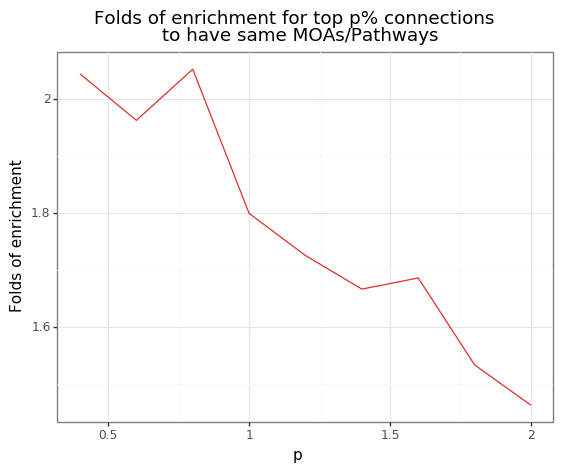

<ggplot: (7028834809)>

In [214]:
(gg.ggplot(data=score,mapping=gg.aes(x='top_perc',y='odds_ratio'))
    + gg.geom_line(color='#de2d26')
    + gg.xlab("p")
    + gg.ylab("Folds of enrichment")
    + gg.labs(title="Folds of enrichment for top p% connections \n to have same MOAs/Pathways")
    + gg.theme_bw()
)